In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community import label_propagation_communities
from tabulate import tabulate
import powerlaw
from scipy.stats import poisson
from numpy import random
from math import e
from scipy.special import factorial
from NEMtropy import UndirectedGraph, DirectedGraph
from NEMtropy.network_functions import build_adjacency_from_edgelist
from NEMtropy import matrix_generator
import datetime
from datetime import timedelta
from datetime import datetime
import arrow
import sys

# Time Frames for timestamp

In [17]:
headerlist = ['bayc', 'coolcats', 'cryptoadz', 'cyberkongz', 'hashmasks', 'mayc', 'meebits', 'mekaverse', 'svs']
titlelist = ['bayc', 'coolcats', 'cryptoadz', 'cyberkongz', 'hashmasks', 'mayc', 'meebits', 'mekaverse', 'svs']
#headerlist = ['bayc', 'cp', 'cv', 'dland', 'hm', 'mcats', 'meebits']

column_names = ["block", "numnodes", "degree_centrality", "closeness_centrality", "betweenness_centrality", "eigenvector_centrality", "avgclustering", "assort", "reciproccoeff", "asscoeff_directed_out_out", "asscoeff_directed_in_in", "asscoeff_directed_in_out", "asscoeff_undirected_base", "avgclustering_rnd", "assort_rnd"]
df_block = pd.DataFrame(columns = column_names)

column_names2 = ["block", "timebucket", "numnodes", "avgclustering", "assort", "reciproccoeff", "asscoeff_directed_out_out", "asscoeff_directed_in_in", "asscoeff_directed_in_out", "asscoeff_undirected_base", "avgclustering_rnd", "assort_rnd"]
df_timebuckets_block = pd.DataFrame(columns = column_names2)

for hh in range(len(headerlist)):
    
    graph = []
    grnd = []
    degree_centrality = []
    closeness_centrality = []
    betweenness_centrality = []
    eigenvector_centrality = []
    
    title = titlelist[hh]
    print(title)
    df = pd.read_csv('netsci-final-project-master/data/collated/'+title+'.csv', delimiter=',', skiprows=1, names=['row','tx_hash','token_address','from_address','to_address','token_id','blk_number','blk_timestamp','eth_value'])
    #df = pd.read_csv('netsci-final-project-master/data/collated/'+title+'.csv', delimiter=',', skiprows=1, names=['row','tx_hash','token_address','from_address','to_address','from_is_contract','to_is_contract','token_id','blk_number','blk_timestamp','eth_value','weth_value','token'])
    
    column_names = ["date", "days_since_mint", "from_address", "to_address", "token_id", "blk_number", "eth_value"]
    df_time = pd.DataFrame(columns = column_names)
    
    column_names2 = ['timebucket', 'k', 'Poisson', 'Exp_Dist', 'Power_Law']
    df_05_1 = pd.DataFrame(columns = column_names2)
    
    # Correct date format
    for index, row in df.iterrows():
        blk_timestamp = row['blk_timestamp']
        bc = arrow.get(blk_timestamp).datetime

        from_address = row['from_address']
        to_address = row['to_address']
        token_id = row['token_id']
        blk_number = row['blk_number']
        eth_value = row['eth_value']
        
        # Get days since mint
        #print(from_address)
        if from_address == ' 0x0000000000000000000000000000000000000000':
            days_since_mint = 0
        elif from_address == '0x0000000000000000000000000000000000000000':
            days_since_mint = 0
        else:
            days_since_mint = 1

        df_time = df_time.append({'date': bc, 'days_since_mint': days_since_mint, 'from_address': from_address, 'to_address': to_address, 'token_id': token_id, 'blk_number': blk_number, 'eth_value': eth_value}, ignore_index=True)
        df_time.to_csv('Export/'+title+'/df_time.csv')
    
    # Days since mint
    for index, row in df_time.iterrows():
        
        days_since_mint = row['days_since_mint']
        
        if days_since_mint == 1:
            date_now = []
            
            from_address = row['from_address']
            date_now = row['date']
            
            dfindex = df.index[df['to_address'] == from_address]
            
            date_mint = df_time.loc[dfindex, 'date']
            #date_mint = date_new.min()
            date_mint = min(date_mint)
            date_diff = date_now - date_mint
            date_diff = date_diff.days
            #date_diff = abs((date_new - date_mint).days)
            df_time.at[dfindex,'days_since_mint'] = date_diff
            
    df_time['days_since_mint'] = df_time['days_since_mint'].fillna(0)
    
    # Building a network per block
    # we will use a weighted and directed graph.
    graph = nx.DiGraph()

    plot_interval = 24 * 3600 * 10 # 1 day
    start_timestamp = df_time['date'].iloc[0]

    # loop over the pandas dataframe.
    for row in df_time.itertuples():

        # read the values from the dataframe.
        # token_id  blk_timestamp	 eth_value	 weth_value
        from_address = row[3].strip()
        to_address = row[4].strip()
        block = row[6]
        timestamp = row[1]
        token_id = row[5]
        eth_value = row[7]

        # make sure both addresses are in the graph.
        if from_address not in graph:
            graph.add_node(from_address)
        if to_address not in graph:
            graph.add_node(to_address)

            # lookup value of both nodes at the time of this block
            # if (not from_address == '0x0000000000000000000000000000000000000000'):
            #     address = w3.toChecksumAddress(from_address)
            #     value_from = w3.eth.get_balance(address, block_identifier=block)
            # if (not to_address == '0x0000000000000000000000000000000000000000'):
            #     address = w3.toChecksumAddress(to_address)
            #     value_to = w3.eth.get_balance(address, block_identifier=block)

            # set the attributes on this node.
            # TODO: replace dummy values
        nx.set_node_attributes(graph, {from_address:100, to_address:100}, 'value')

        # keep track of how many trades a wallet has done.
        trades = nx.get_node_attributes(graph, "trades")
        if from_address in trades:
            nx.set_node_attributes(graph, {from_address:trades[from_address] + 1}, 'trades')
        else:
            nx.set_node_attributes(graph, {from_address:1}, 'trades')
        if to_address in trades:
            nx.set_node_attributes(graph, {to_address:trades[to_address] + 1}, 'trades')
        else:
            nx.set_node_attributes(graph, {to_address:1}, 'trades')

            # check if this NFT has already been sold and if yes, remove the old sale.
        removeEdges = []
        for (u,v,d) in graph.edges.data():
            if d['token'] == token_id:
                removeEdges.append((u,v))
            # we need to remove them in a seperate step, since otherwise we change the datastructure that we are iterating over.
        for (u,v) in removeEdges:
            graph.remove_edge(u,v)

        # add an edge for the transaction.
        #value = eth_value + weth_value # currently we do not care if it was eth or weth
        value = eth_value # currently we do not care if it was eth or weth
        graph.add_edge(from_address, to_address, weight=value, token=token_id) # keep track of token id by adding it to the edge.

    # Directed
    avgclustering = nx.average_clustering(graph)
    assort = nx.degree_assortativity_coefficient(graph)
    reciproccoeff = nx.reciprocity(graph)
    asscoeff_directed_out_out = nx.degree_pearson_correlation_coefficient(graph, x='out', y='out', weight='weight')
    asscoeff_directed_in_in = nx.degree_pearson_correlation_coefficient(graph, x='in', y='in', weight='weight')
    asscoeff_directed_in_out = nx.degree_pearson_correlation_coefficient(graph, x='in', y='out', weight='weight')
    ## Graph is not weakly connected:
    #avgpathlength = nx.average_shortest_path_length(graph)
    ## Found infinite path length because the digraph is not strongly connected
    #diameter = nx.diameter(graph)
    numnodes = graph.number_of_nodes()

    # Undirected
    asscoeff_undirected_base = nx.degree_pearson_correlation_coefficient(graph.to_undirected(), weight='weight')

    ## Randomize
    #grnd = nx.algorithms.smallworld.random_reference(graph.to_undirected(),niter = 10, connectivity=False)
    #avgclustering_rnd = nx.average_clustering(grnd)
    #assort_rnd = nx.degree_assortativity_coefficient(grnd)
    ##avgpathlength_rnd = nx.average_shortest_path_length(grnd)
    ##diameter_rnd = nx.diameter(grnd)
    
    degree_centrality = nx.degree_centrality(graph)
    closeness_centrality = nx.closeness_centrality(graph)
    betweenness_centrality = nx.betweenness_centrality(graph)
    eigenvector_centrality = nx.eigenvector_centrality(graph)
    
    df_block = df_block.append({'block': title, 'numnodes': numnodes, 'degree_centrality': degree_centrality, 'closeness_centrality': closeness_centrality, 'betweenness_centrality': betweenness_centrality, 'eigenvector_centrality': eigenvector_centrality, 'avgclustering': avgclustering, 'assort': assort, 'reciproccoeff': reciproccoeff, 'asscoeff_directed_out_out': asscoeff_directed_out_out, 'asscoeff_directed_in_in': asscoeff_directed_in_in, 'asscoeff_directed_in_out': asscoeff_directed_in_out, 'asscoeff_undirected_base': asscoeff_undirected_base}, ignore_index=True)
    df_block.to_csv('Export/'+title+'/df_block.csv')
    
    # --------------- Unique Wallts ---------------
    
    column_names = ['days_since_mint', 'from_addresses', 'to_addresses', 'delta']
    unique_wallets = pd.DataFrame(columns = column_names)

    column_values = df_time[["days_since_mint"]].values
    unique_values = np.unique(column_values)

    for hh in range(len(unique_values)):

        df_temp = df_time.loc[(df_time['days_since_mint'] <= hh)]

        num_from = df_temp[["from_address"]].values
        num_from_unique =  np.unique(num_from)
        from_addresses = len(num_from_unique)

        num_to = df_temp[["to_address"]].values
        num_to_unique =  np.unique(num_to)
        to_addresses = len(num_to_unique)

        delta = to_addresses - from_addresses

        #for index, row in df_time.iterrows():
        #    days_since_mint = row['days_since_mint']
        #    print(days_since_mint)

        unique_wallets = unique_wallets.append({'days_since_mint': hh, 'from_addresses': from_addresses, 'to_addresses': to_addresses, 'delta': delta}, ignore_index=True)
        unique_wallets.to_csv('Export/'+title+'/unique_wallets.csv')
    
    fig, ax = plt.subplots(figsize=(10, 6))
    fig.suptitle('Date vs. eth_value', fontsize=20, y=1.1, ha="center")
    #plt.xscale('log')
    plt.xlabel("Date after mint")
    plt.ylabel("Num. of unique owners")
    plt.plot(unique_wallets.days_since_mint, unique_wallets.delta, label='Base')
    plt.legend(bbox_to_anchor=(1.05, 1))
    
    # -------------------------------------------
    
    # eth_value over time
    #fig = plt.figure(1, figsize=(8, 5), dpi=60)
    fig, ax = plt.subplots(figsize=(10, 6))
    fig.suptitle('Date vs. eth_value', fontsize=20, y=1.1, ha="center")
    #plt.xscale('log')
    plt.xlabel("date")
    plt.ylabel("eth_value")
    plt.plot(df_time.date, df_time.eth_value, label='Base')
    plt.legend(bbox_to_anchor=(1.05, 1))
    
    ## eth_value over days since mint
    #fig = plt.figure(1, figsize=(8, 5), dpi=60)
    #fig.suptitle('Reciprocity', fontsize=20, y=1.1, ha="center")
    #plt.subplots(figsize=(10, 6))
    ##plt.xscale('log')
    #plt.xlabel("date")
    #plt.ylabel("days_since_mint")
    #plt.plot(df_time.date, df_time.days_since_mint, label='Base')
    #plt.legend(bbox_to_anchor=(1.05, 1))
    
    df_time_2 = df_time.sort_values(by=['days_since_mint'])
    df_time_2 = df_time.groupby(by=["days_since_mint"]).sum()

    # eth_value over days since mint
    #fig = plt.figure(1, figsize=(8, 5), dpi=60)
    fig, ax = plt.subplots(figsize=(10, 6))
    fig.suptitle('Date since mint vs. eth_value', fontsize=20, y=1.1, ha="center")
    #plt.xscale('log')
    plt.xlabel("days_since_mint")
    plt.ylabel("eth_value")
    plt.plot(df_time_2.index, df_time_2.eth_value, label='Base')
    plt.legend(bbox_to_anchor=(1.05, 1))
    
    fig, ax = plt.subplots(figsize=(10, 6))
    fig.suptitle('Number of transactions over time', fontsize=20, y=1.1, ha="center")
    plt.hist(df_time.date)
    plt.show()
    
    # Centrality measures
    fig, ax = plt.subplots(figsize=(10, 6))
    fig.suptitle('1. Degree ki vs. Closeness ci', fontsize=20, y=1.1, ha="center")
    plt.scatter([degree_centrality[x] for x in degree_centrality], [closeness_centrality[y] for y in closeness_centrality])
    plt.xlabel("Degree k")
    plt.ylabel("Closeness c")
    plt.show()
    
    fig, ax = plt.subplots(figsize=(10, 6))
    fig.suptitle('2. Degree ki vs. Betweenness bi', fontsize=20, y=1.1, ha="center")
    plt.scatter([degree_centrality[x] for x in degree_centrality], [betweenness_centrality[y] for y in betweenness_centrality])
    plt.xlabel("Degree k")
    plt.ylabel("Betweenness b")

    fig, ax = plt.subplots(figsize=(10, 6))
    fig.suptitle('3. Degree ki vs. Eigenvector ei', fontsize=20, y=1.1, ha="center")
    plt.scatter([degree_centrality[x] for x in degree_centrality], [eigenvector_centrality[y] for y in eigenvector_centrality])
    plt.xlabel("Degree k")
    plt.ylabel("Eigenvector e")

    fig, ax = plt.subplots(figsize=(10, 6))
    fig.suptitle('4. Closeness ci vs. Betweenness bi', fontsize=20, y=1.1, ha="center")
    plt.scatter([closeness_centrality[x] for x in closeness_centrality], [betweenness_centrality[y] for y in betweenness_centrality])
    plt.xlabel("Closeness c")
    plt.ylabel("Betweenness b")

    fig, ax = plt.subplots(figsize=(10, 6))
    fig.suptitle('5. Closeness ci bs. Eigenvector ei', fontsize=20, y=1.1, ha="center")
    plt.scatter([closeness_centrality[x] for x in closeness_centrality], [eigenvector_centrality[y] for y in eigenvector_centrality])
    plt.xlabel("Closeness c")
    plt.ylabel("Betweenness b")

    fig, ax = plt.subplots(figsize=(10, 6))
    fig.suptitle('6. Betweenness bi vs. Eigenvector ei', fontsize=20, y=1.1, ha="center")
    plt.scatter([betweenness_centrality[x] for x in betweenness_centrality], [eigenvector_centrality[y] for y in eigenvector_centrality])
    plt.xlabel("Betweenness b")
    plt.ylabel("Eigenvector e")
    
    # _______________ per time bucket _______________
    
    df_time['date_quantile'] = pd.qcut(df_time['date'], 10, labels=False)
    #df_time['date_quantile'] = pd.qcut(df_time['days_since_mint'], 10, labels=False)

    column_names = ["timebucket", "numnodes", "avgclustering", "assort", "reciproccoeff", "asscoeff_directed_out_out", "asscoeff_directed_in_in", "asscoeff_directed_in_out", "asscoeff_undirected_base", "avgclustering_rnd", "assort_rnd"]
    df_timebuckets = pd.DataFrame(columns = column_names)
    
    column_names = ['run', 'p', 'averageprob']
    df_prob = pd.DataFrame(columns = column_names)

    timebuckets = df_time["date_quantile"].to_numpy()
    timebuckets = np.unique(timebuckets)

    for jj in range(len(timebuckets)):
        df_timebucket = df_time[(df_time['date_quantile'] <= jj)]

        # we will use a weighted and directed graph.
        graph = nx.DiGraph()

        plot_interval = 24 * 3600 * 10 # 1 day
        start_timestamp = df_timebucket['date'].iloc[0]

        # loop over the pandas dataframe.
        for row in df_timebucket.itertuples():

            # read the values from the dataframe.
            # token_id  blk_timestamp	 eth_value	 weth_value
            from_address = row[3].strip()
            to_address = row[4].strip()
            block = row[6]
            timestamp = row[1]
            token_id = row[5]
            eth_value = row[7]

            # make sure both addresses are in the graph.
            if from_address not in graph:
                 graph.add_node(from_address)
            if to_address not in graph:
                graph.add_node(to_address)

            # lookup value of both nodes at the time of this block
            # if (not from_address == '0x0000000000000000000000000000000000000000'):
            #     address = w3.toChecksumAddress(from_address)
            #     value_from = w3.eth.get_balance(address, block_identifier=block)
            # if (not to_address == '0x0000000000000000000000000000000000000000'):
            #     address = w3.toChecksumAddress(to_address)
            #     value_to = w3.eth.get_balance(address, block_identifier=block)

            # set the attributes on this node.
            # TODO: replace dummy values
            nx.set_node_attributes(graph, {from_address:100, to_address:100}, 'value')

            # keep track of how many trades a wallet has done.
            trades = nx.get_node_attributes(graph, "trades")
            if from_address in trades:
                nx.set_node_attributes(graph, {from_address:trades[from_address] + 1}, 'trades')
            else:
                nx.set_node_attributes(graph, {from_address:1}, 'trades')
            if to_address in trades:
                nx.set_node_attributes(graph, {to_address:trades[to_address] + 1}, 'trades')
            else:
                nx.set_node_attributes(graph, {to_address:1}, 'trades')

            # check if this NFT has already been sold and if yes, remove the old sale.
            removeEdges = []
            for (u,v,d) in graph.edges.data():
                if d['token'] == token_id:
                    removeEdges.append((u,v))
            # we need to remove them in a seperate step, since otherwise we change the datastructure that we are iterating over.
            for (u,v) in removeEdges:
                graph.remove_edge(u,v)

            # add an edge for the transaction.
            #value = eth_value + weth_value # currently we do not care if it was eth or weth
            value = eth_value # currently we do not care if it was eth or weth
            graph.add_edge(from_address, to_address, weight=value, token=token_id) # keep track of token id by adding it to the edge.

                
            # --------------- Power-Law ---------------
            
            k = np.asarray([d for d in dict(graph.degree()).values()])
            k = np.asarray(k, dtype=np.integer)

            avg_k = np.average(k)
            #spacing = np.linspace(min(k),max(k),len(k))
            spacing = np.logspace(np.log10(min(k)), np.log10(max(k)), len(k))

            fit = powerlaw.Fit(k)
            alpha = fit.power_law.alpha
            sigma = fit.power_law.sigma
            alpha_constant = f"Alpha: {round(alpha, 2)}"
            sigma_constant = f"Sigma: {round(sigma, 2)}"
            alpha_sigma_constant = f"{alpha_constant}, {sigma_constant}"

            #fig, ax = plt.subplots(1, 1)
            fig, ax = plt.subplots(figsize=(10, 5))

            # Fit PDF
            fit.power_law.plot_pdf(color='r')

            # PDF

            ## cannot convert float infinity to integer
            #def round_int(x):
            #    if x in [float("-inf"),float("inf")]: return float("nan")
            #     return int(round(x))
            #round_int(k)

            #powerlaw.plot_pdf(k,color='b',marker='o')
            #plt.plot(spacing,myfunc(spacing,4))

            numnodes = graph.number_of_nodes()
            sumdegree = sum(k)

            # Lambda: mean number of successes that occur during a specific interval
            k_a = sumdegree / numnodes

            # k: number of successes
            num_k = len(k)

            #title = titlelist[jj]

            for i in spacing:
                fact_k = factorial(i, exact=False)
                poisson = (k_a**i / fact_k) * e**(-1*k_a)
                exp_dist = k_a**(-1) * e**(-i/k_a)
                power_law = i**(-2.5)

                df_05_1 = df_05_1.append({'timebucket': jj, 'k': i, 'Poisson': poisson, 'Exp_Dist': exp_dist, 'Power_Law': power_law}, ignore_index=True)
                df_05_1.to_csv('Export/'+title+'/df_05_1.csv')

            ax = plt.gca()

            fig.suptitle(title, fontsize=20, y=1.1, ha="center")
            plt.scatter(df_05_1.k, df_05_1.Power_Law, label='Power-Law Distribution', s=15, color='blue')
            plt.scatter(df_05_1.k, df_05_1.Poisson, label='Poisson', s=15, color='green')
            plt.scatter(df_05_1.k, df_05_1.Exp_Dist, label='Exponential Distribution', s=15, color='lightgreen')
            plt.legend(['Fit PDF', 'PDF', 'Poisson', 'Exp_Dist'], loc = 'upper right')
            plt.text(1, 1, alpha_sigma_constant, fontsize = 10)

            ymin = 10**(-8)
            ymax = 10**1
            ax = plt.gca()
            ax.set_ylim([ymin, ymax])

            plt.show()
            #df_05_1 = df_05_1[0:0]
            
            # ---------------------------------------
        
            
        # Directed
        avgclustering = nx.average_clustering(graph)
        assort = nx.degree_assortativity_coefficient(graph)
        reciproccoeff = nx.reciprocity(graph)
        asscoeff_directed_out_out = nx.degree_pearson_correlation_coefficient(graph, x='out', y='out', weight='weight')
        asscoeff_directed_in_in = nx.degree_pearson_correlation_coefficient(graph, x='in', y='in', weight='weight')
        asscoeff_directed_in_out = nx.degree_pearson_correlation_coefficient(graph, x='in', y='out', weight='weight')
        ## Graph is not weakly connected:
        #avgpathlength = nx.average_shortest_path_length(graph)
        ## Found infinite path length because the digraph is not strongly connected
        #diameter = nx.diameter(graph)
        numnodes = graph.number_of_nodes()

        # Undirected

        #p_values = np.logspace(np.log10(0.0000000001), np.log10(1), 100)
        #runs = 100
        #for p in p_values:
        #    for i in range(runs):
        #        components = [c for c in nx.connected_components(graph.to_undirected())]
        #        maxcomp = max(components, key=len)
        #        averageprob = len(maxcomp)/graph.to_undirected().number_of_nodes()
        #        df_prob = df_prob.append({'run': i, 'p': p, 'averageprob': averageprob}, ignore_index=True)

        asscoeff_undirected_base = nx.degree_pearson_correlation_coefficient(graph.to_undirected(), weight='weight')

        # Randomize
        grnd = nx.algorithms.smallworld.random_reference(graph.to_undirected(),niter = 10, connectivity=False)
        avgclustering_rnd = nx.average_clustering(grnd)
        assort_rnd = nx.degree_assortativity_coefficient(grnd)
        #avgpathlength_rnd = nx.average_shortest_path_length(grnd)
        #diameter_rnd = nx.diameter(grnd)

        df_timebuckets = df_timebuckets.append({'timebucket': jj, 'numnodes': numnodes, 'avgclustering': avgclustering, 'assort': assort, 'reciproccoeff': reciproccoeff, 'asscoeff_directed_out_out': asscoeff_directed_out_out, 'asscoeff_directed_in_in': asscoeff_directed_in_in, 'asscoeff_directed_in_out': asscoeff_directed_in_out, 'asscoeff_undirected_base': asscoeff_undirected_base, 'avgclustering_rnd': avgclustering_rnd, 'assort_rnd': assort_rnd}, ignore_index=True)
        df_timebuckets.to_csv('Export/'+title+'/df_timebuckets.csv')
        df_timebuckets_block = df_timebuckets.append({'block': title, 'timebucket': jj, 'numnodes': numnodes, 'avgclustering': avgclustering, 'assort': assort, 'reciproccoeff': reciproccoeff, 'asscoeff_directed_out_out': asscoeff_directed_out_out, 'asscoeff_directed_in_in': asscoeff_directed_in_in, 'asscoeff_directed_in_out': asscoeff_directed_in_out, 'asscoeff_undirected_base': asscoeff_undirected_base, 'avgclustering_rnd': avgclustering_rnd, 'assort_rnd': assort_rnd}, ignore_index=True)
        df_timebuckets_block.to_csv('Export/'+title+'/df_timebuckets_block.csv')
        # df_timebuckets = df_timebuckets.append({'timebucket': jj, 'numnodes': numnodes, 'averageprob': averageprob, 'avgclustering': avgclustering, 'assort': assort, 'reciproccoeff': reciproccoeff, 'asscoeff_directed_out_out': asscoeff_directed_out_out, 'asscoeff_directed_in_in': asscoeff_directed_in_in, 'asscoeff_directed_in_out': asscoeff_directed_in_out, 'asscoeff_undirected_base': asscoeff_undirected_base, 'avgclustering_rnd': avgclustering_rnd, 'assort_rnd': assort_rnd}, ignore_index=True)


    df_timebuckets = df_timebuckets.sort_values(by=['timebucket'])

    fig = plt.figure(1, figsize=(8, 5), dpi=60)
    fig.suptitle('Clustering / Reciprocity', fontsize=20, y=1.1, ha="center")
    plt.subplots(figsize=(10, 6))
    #plt.xscale('log')
    plt.xlabel("Week")
    plt.ylabel("Clustering / Reciprocity")
    plt.plot(df_timebuckets.timebucket, df_timebuckets.numnodes, label='Number of nodes')
    plt.legend(bbox_to_anchor=(1.05, 1))

    fig = plt.figure(1, figsize=(8, 5), dpi=60)   
    fig.suptitle('Clustering / Reciprocity', fontsize=20, y=1.1, ha="center")
    plt.subplots(figsize=(10, 6))
    #plt.xscale('log')
    plt.xlabel("Week")
    plt.ylabel("Clustering / Reciprocity")
    plt.plot(df_timebuckets.timebucket, df_timebuckets.avgclustering, label='avgclustering')
    plt.plot(df_timebuckets.timebucket, df_timebuckets.reciproccoeff, label='reciproccoeff')
    plt.legend(bbox_to_anchor=(1.05, 1))

    fig = plt.figure(1, figsize=(8, 5), dpi=60)   
    fig.suptitle('Strength Assortativity', fontsize=20, y=1.1, ha="center")
    plt.subplots(figsize=(10, 6))
    #plt.xscale('log')
    plt.xlabel("Week")
    plt.ylabel("Strength Assortativity")
    plt.plot(df_timebuckets.timebucket, df_timebuckets.asscoeff_directed_out_out, label='asscoeff_directed_out_out')
    plt.plot(df_timebuckets.timebucket, df_timebuckets.asscoeff_directed_in_in, label='asscoeff_directed_in_in')
    plt.plot(df_timebuckets.timebucket, df_timebuckets.asscoeff_directed_in_out, label='asscoeff_directed_in_out')
    plt.plot(df_timebuckets.timebucket, df_timebuckets.asscoeff_undirected_base, label='asscoeff_undirected_base')
    plt.legend(bbox_to_anchor=(1.05, 1))


    df_timebuckets = df_timebuckets.sort_values(by=['numnodes'])

    fig = plt.figure(1, figsize=(8, 5), dpi=60)   
    fig.suptitle('Average Clustering', fontsize=20, y=1.1, ha="center")
    plt.subplots(figsize=(10, 6))
    plt.xscale('log')
    plt.xlabel(r"$\mathcal{N}$")
    plt.ylabel("Average Clustering")
    plt.plot(df_timebuckets.numnodes, df_timebuckets.avgclustering, label='Real')
    plt.plot(df_timebuckets.numnodes, df_timebuckets.avgclustering_rnd, label='Randomized')
    plt.legend(bbox_to_anchor=(1.05, 1))

    fig = plt.figure(1, figsize=(8, 5), dpi=60)   
    fig.suptitle('Assortativity', fontsize=20, y=1.1, ha="center")
    plt.subplots(figsize=(10, 6))
    plt.xscale('log')
    plt.xlabel(r"$\mathcal{N}$")
    plt.ylabel("Assortativity")
    plt.plot(df_timebuckets.numnodes, df_timebuckets.assort, label='Real')
    plt.plot(df_timebuckets.numnodes, df_timebuckets.assort_rnd, label='Randomized')
    plt.legend(bbox_to_anchor=(1.05, 1))

    fig = plt.figure(1, figsize=(8, 5), dpi=60)   
    fig.suptitle('Correlation Coefficient', fontsize=20, y=1.1, ha="center")
    plt.subplots(figsize=(10, 6))
    plt.xscale('log')
    plt.xlabel(r"$\mathcal{N}$")
    plt.ylabel("Correlation Coefficient")
    plt.plot(df_timebuckets.numnodes, df_timebuckets.asscoeff_directed_out_out, label='asscoeff_directed_out_out')
    plt.plot(df_timebuckets.numnodes, df_timebuckets.asscoeff_directed_in_in, label='asscoeff_directed_in_in')
    plt.plot(df_timebuckets.numnodes, df_timebuckets.asscoeff_directed_in_out, label='asscoeff_directed_in_out')
    plt.plot(df_timebuckets.numnodes, df_timebuckets.asscoeff_undirected_base, label='asscoeff_undirected_base')
    plt.legend(bbox_to_anchor=(1.05, 1))

    

bayc


KeyboardInterrupt: 

In [13]:
df_time

,date,days_since_mint,from_address,to_address,token_id,blk_number,eth_value
0,2021-04-22 23:13:40+00:00,0,0x0000000000000000000000000000000000000000,0xaba7161a7fb69c88e16ed9f455ce62b791ee4d03,0,12292922,0.0


In [16]:
title

'bayc'

In [14]:
path = 'Export/'+hh+'/df_time.csv'
path

TypeError: can only concatenate str (not "int") to str

<Figure size 480x300 with 0 Axes>

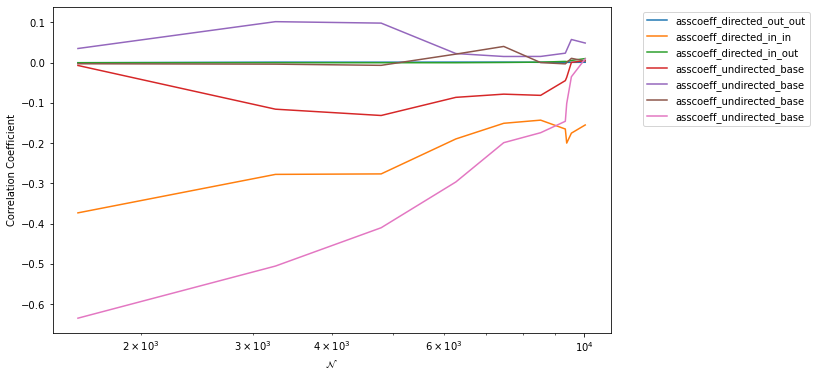

In [8]:
fig = plt.figure(1, figsize=(8, 5), dpi=60)   
fig.suptitle('Correlation Coefficient', fontsize=20, y=1.1, ha="center")
plt.subplots(figsize=(10, 6))
plt.xscale('log')
plt.xlabel(r"$\mathcal{N}$")
plt.ylabel("Correlation Coefficient")
plt.plot(df_timebuckets.numnodes, df_timebuckets.avgclustering, label='asscoeff_directed_out_out')
plt.plot(df_timebuckets.numnodes, df_timebuckets.assort, label='asscoeff_directed_in_in')
plt.plot(df_timebuckets.numnodes, df_timebuckets.reciproccoeff, label='asscoeff_directed_in_out')
plt.plot(df_timebuckets.numnodes, df_timebuckets.asscoeff_directed_out_out, label='asscoeff_undirected_base')
plt.plot(df_timebuckets.numnodes, df_timebuckets.asscoeff_directed_in_in, label='asscoeff_undirected_base')
plt.plot(df_timebuckets.numnodes, df_timebuckets.asscoeff_directed_in_out, label='asscoeff_undirected_base')
plt.plot(df_timebuckets.numnodes, df_timebuckets.asscoeff_undirected_base, label='asscoeff_undirected_base')
plt.legend(bbox_to_anchor=(1.05, 1))

# Measures according to A05 (as Power-Law)

<ipython-input-24-22b50795a5dc>:106: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  k = np.asarray(k, dtype=np.integer)


Calculating best minimal value for power law fit


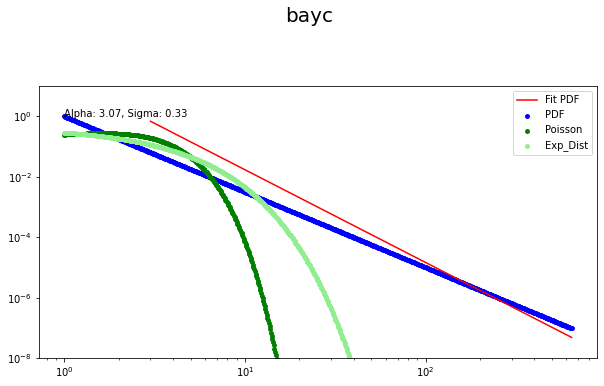

<ipython-input-24-22b50795a5dc>:106: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  k = np.asarray(k, dtype=np.integer)


Calculating best minimal value for power law fit


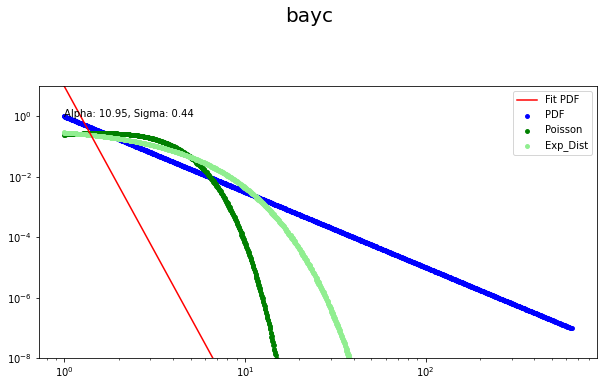

<ipython-input-24-22b50795a5dc>:106: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  k = np.asarray(k, dtype=np.integer)
<ipython-input-24-22b50795a5dc>:110: RuntimeWarning: divide by zero encountered in log10
  spacing = np.logspace(np.log10(min(k)), np.log10(max(k)), len(k))
C:\Users\pell\Anaconda3\lib\site-packages\numpy\core\function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
C:\Users\pell\Anaconda3\lib\site-packages\numpy\core\function_base.py:161: RuntimeWarning: invalid value encountered in add
  y += start
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


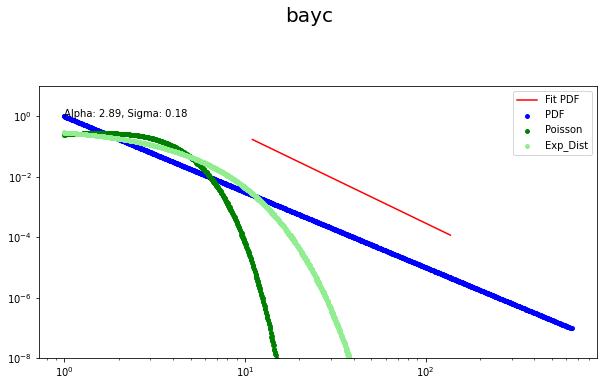

<ipython-input-24-22b50795a5dc>:106: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  k = np.asarray(k, dtype=np.integer)
<ipython-input-24-22b50795a5dc>:110: RuntimeWarning: divide by zero encountered in log10
  spacing = np.logspace(np.log10(min(k)), np.log10(max(k)), len(k))
C:\Users\pell\Anaconda3\lib\site-packages\numpy\core\function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
C:\Users\pell\Anaconda3\lib\site-packages\numpy\core\function_base.py:161: RuntimeWarning: invalid value encountered in add
  y += start
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


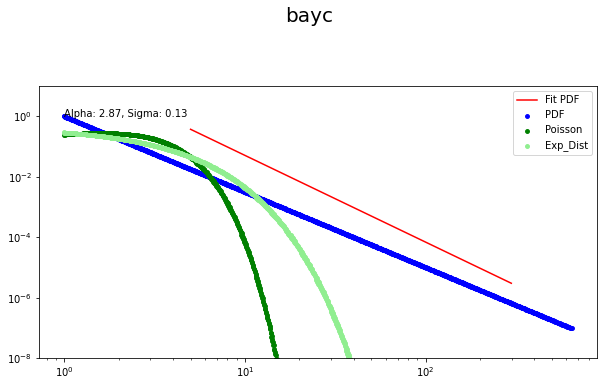

<ipython-input-24-22b50795a5dc>:106: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  k = np.asarray(k, dtype=np.integer)
<ipython-input-24-22b50795a5dc>:110: RuntimeWarning: divide by zero encountered in log10
  spacing = np.logspace(np.log10(min(k)), np.log10(max(k)), len(k))
C:\Users\pell\Anaconda3\lib\site-packages\numpy\core\function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
C:\Users\pell\Anaconda3\lib\site-packages\numpy\core\function_base.py:161: RuntimeWarning: invalid value encountered in add
  y += start
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


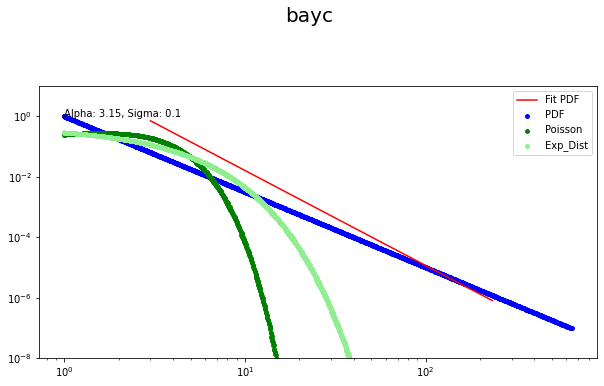

<ipython-input-24-22b50795a5dc>:106: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  k = np.asarray(k, dtype=np.integer)
<ipython-input-24-22b50795a5dc>:110: RuntimeWarning: divide by zero encountered in log10
  spacing = np.logspace(np.log10(min(k)), np.log10(max(k)), len(k))
C:\Users\pell\Anaconda3\lib\site-packages\numpy\core\function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
C:\Users\pell\Anaconda3\lib\site-packages\numpy\core\function_base.py:161: RuntimeWarning: invalid value encountered in add
  y += start
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


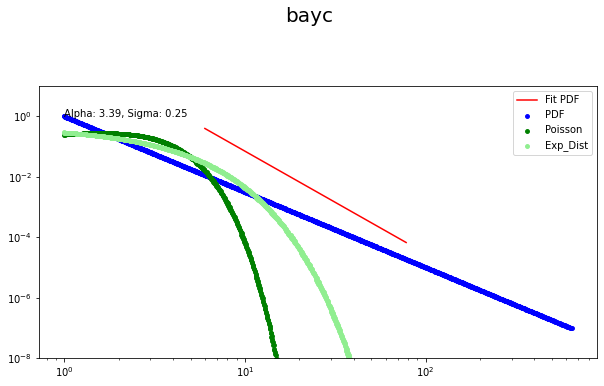

<ipython-input-24-22b50795a5dc>:106: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  k = np.asarray(k, dtype=np.integer)
<ipython-input-24-22b50795a5dc>:110: RuntimeWarning: divide by zero encountered in log10
  spacing = np.logspace(np.log10(min(k)), np.log10(max(k)), len(k))
C:\Users\pell\Anaconda3\lib\site-packages\numpy\core\function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
C:\Users\pell\Anaconda3\lib\site-packages\numpy\core\function_base.py:161: RuntimeWarning: invalid value encountered in add
  y += start
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


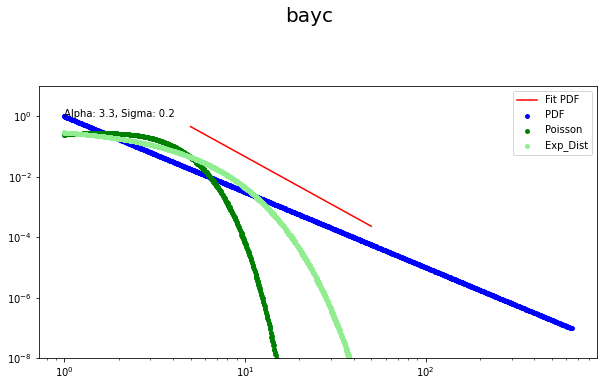

<ipython-input-24-22b50795a5dc>:106: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  k = np.asarray(k, dtype=np.integer)
<ipython-input-24-22b50795a5dc>:110: RuntimeWarning: divide by zero encountered in log10
  spacing = np.logspace(np.log10(min(k)), np.log10(max(k)), len(k))
C:\Users\pell\Anaconda3\lib\site-packages\numpy\core\function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
C:\Users\pell\Anaconda3\lib\site-packages\numpy\core\function_base.py:161: RuntimeWarning: invalid value encountered in add
  y += start
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


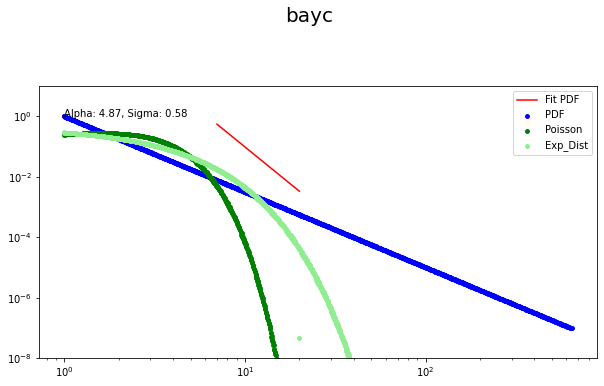

<ipython-input-24-22b50795a5dc>:106: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  k = np.asarray(k, dtype=np.integer)
<ipython-input-24-22b50795a5dc>:110: RuntimeWarning: divide by zero encountered in log10
  spacing = np.logspace(np.log10(min(k)), np.log10(max(k)), len(k))
C:\Users\pell\Anaconda3\lib\site-packages\numpy\core\function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
C:\Users\pell\Anaconda3\lib\site-packages\numpy\core\function_base.py:161: RuntimeWarning: invalid value encountered in add
  y += start
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


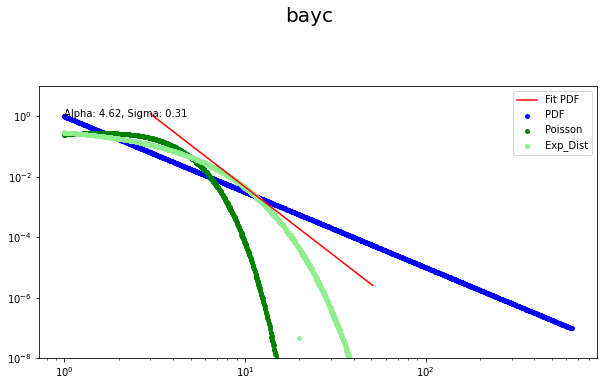

<ipython-input-24-22b50795a5dc>:106: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  k = np.asarray(k, dtype=np.integer)
<ipython-input-24-22b50795a5dc>:110: RuntimeWarning: divide by zero encountered in log10
  spacing = np.logspace(np.log10(min(k)), np.log10(max(k)), len(k))
C:\Users\pell\Anaconda3\lib\site-packages\numpy\core\function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
C:\Users\pell\Anaconda3\lib\site-packages\numpy\core\function_base.py:161: RuntimeWarning: invalid value encountered in add
  y += start
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


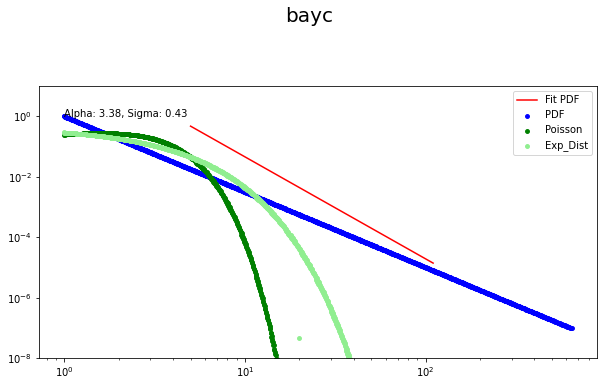

In [24]:
column_names = ["timebucket", "avgclustering", "reciproccoeff", "asscoeff_directed_out_out", "asscoeff_directed_in_in", "asscoeff_directed_in_out", "asscoeff_undirected_base"]
#column_names = ["timebucket", "k", "Poisson", "Exp_Dist", "avgclustering", "reciproccoeff", "asscoeff_directed_out_out", "asscoeff_directed_in_in", "asscoeff_directed_in_out", "asscoeff_undirected_base"]
df_timebuckets = pd.DataFrame(columns = column_names)

column_names2 = ['timebucket', 'k', 'Poisson', 'Exp_Dist', 'Power_Law']
df_05_1 = pd.DataFrame(columns = column_names2)

# !!!!!!
df_time.round({'eth_value': 2})

timebuckets = df_time["date_quantile"].to_numpy()
timebuckets = np.unique(timebuckets)

for jj in range(len(timebuckets)):
    
    k = []
    
    if jj != 20:
    
        df_timebucket = df_time[(df_time['date_quantile'] == jj)]

        # we will use a weighted and directed graph.
        graph = nx.DiGraph()

        plot_interval = 24 * 3600 * 10 # 1 day
        start_timestamp = df_timebucket['date'].iloc[0]

        # loop over the pandas dataframe.
        for row in df_timebucket.itertuples():

            # read the values from the dataframe.
            # token_id  blk_timestamp	 eth_value	 weth_value
            from_address = row[3].strip()
            to_address = row[4].strip()
            block = row[6]
            timestamp = row[1]
            token_id = row[5]
            eth_value = row[7]
            weth_value = row[8]

            # make sure both addresses are in the graph.
            if from_address not in graph:
                 graph.add_node(from_address)
            if to_address not in graph:
                graph.add_node(to_address)

            # lookup value of both nodes at the time of this block
            # if (not from_address == '0x0000000000000000000000000000000000000000'):
            #     address = w3.toChecksumAddress(from_address)
            #     value_from = w3.eth.get_balance(address, block_identifier=block)
            # if (not to_address == '0x0000000000000000000000000000000000000000'):
            #     address = w3.toChecksumAddress(to_address)
            #     value_to = w3.eth.get_balance(address, block_identifier=block)

            # set the attributes on this node.
            # TODO: replace dummy values
            nx.set_node_attributes(graph, {from_address:100, to_address:100}, 'value')

            # keep track of how many trades a wallet has done.
            trades = nx.get_node_attributes(graph, "trades")
            if from_address in trades:
                nx.set_node_attributes(graph, {from_address:trades[from_address] + 1}, 'trades')
            else:
                nx.set_node_attributes(graph, {from_address:1}, 'trades')
            if to_address in trades:
                nx.set_node_attributes(graph, {to_address:trades[to_address] + 1}, 'trades')
            else:
                nx.set_node_attributes(graph, {to_address:1}, 'trades')

            # check if this NFT has already been sold and if yes, remove the old sale.
            removeEdges = []
            for (u,v,d) in graph.edges.data():
                if d['token'] == token_id:
                    removeEdges.append((u,v))
            # we need to remove them in a seperate step, since otherwise we change the datastructure that we are iterating over.
            for (u,v) in removeEdges:
                graph.remove_edge(u,v)

            # add an edge for the transaction.
            value = eth_value + weth_value # currently we do not care if it was eth or weth
            graph.add_edge(from_address, to_address, weight=value, token=token_id) # keep track of token id by adding it to the edge.

        # Directed
        avgclustering = nx.average_clustering(graph)
        reciproccoeff = nx.reciprocity(graph)
        asscoeff_directed_out_out = nx.degree_pearson_correlation_coefficient(graph, x='out', y='out', weight='weight')
        asscoeff_directed_in_in = nx.degree_pearson_correlation_coefficient(graph, x='in', y='in', weight='weight')
        asscoeff_directed_in_out = nx.degree_pearson_correlation_coefficient(graph, x='in', y='out', weight='weight')

        # Undirected
        asscoeff_undirected_base = nx.degree_pearson_correlation_coefficient(graph.to_undirected(), weight='weight')

        df_timebuckets = df_timebuckets.append({'timebucket': jj, 'avgclustering': avgclustering, 'reciproccoeff': reciproccoeff, 'asscoeff_directed_out_out': asscoeff_directed_out_out, 'asscoeff_directed_in_in': asscoeff_directed_in_in, 'asscoeff_directed_in_out': asscoeff_directed_in_out, 'asscoeff_undirected_base': asscoeff_undirected_base}, ignore_index=True)


        k = np.asarray([d for d in dict(graph.degree()).values()])

        # !!!!!!
        k = np.asarray(k, dtype=np.integer)

        avg_k = np.average(k)
        #spacing = np.linspace(min(k),max(k),len(k))
        spacing = np.logspace(np.log10(min(k)), np.log10(max(k)), len(k))

        fit = powerlaw.Fit(k)
        alpha = fit.power_law.alpha
        sigma = fit.power_law.sigma
        alpha_constant = f"Alpha: {round(alpha, 2)}"
        sigma_constant = f"Sigma: {round(sigma, 2)}"
        alpha_sigma_constant = f"{alpha_constant}, {sigma_constant}"

        #fig, ax = plt.subplots(1, 1)
        fig, ax = plt.subplots(figsize=(10, 5))

        # Fit PDF
        fit.power_law.plot_pdf(color='r')

        # PDF

        ## cannot convert float infinity to integer
        #def round_int(x):
        #    if x in [float("-inf"),float("inf")]: return float("nan")
        #     return int(round(x))
        #round_int(k)

        #powerlaw.plot_pdf(k,color='b',marker='o')
        #plt.plot(spacing,myfunc(spacing,4))

        numnodes = graph.number_of_nodes()
        sumdegree = sum(k)

        # Lambda: mean number of successes that occur during a specific interval
        k_a = sumdegree / numnodes

        # k: number of successes
        num_k = len(k)

        #title = titlelist[jj]

        for i in spacing:
            fact_k = factorial(i, exact=False)
            poisson = (k_a**i / fact_k) * e**(-1*k_a)
            exp_dist = k_a**(-1) * e**(-i/k_a)
            power_law = i**(-2.5)

            df_05_1 = df_05_1.append({'timebucket': jj, 'k': i, 'Poisson': poisson, 'Exp_Dist': exp_dist, 'Power_Law': power_law}, ignore_index=True)

        ax = plt.gca()

        fig.suptitle(title, fontsize=20, y=1.1, ha="center")
        plt.scatter(df_05_1.k, df_05_1.Power_Law, label='Power-Law Distribution', s=15, color='blue')
        plt.scatter(df_05_1.k, df_05_1.Poisson, label='Poisson', s=15, color='green')
        plt.scatter(df_05_1.k, df_05_1.Exp_Dist, label='Exponential Distribution', s=15, color='lightgreen')
        plt.legend(['Fit PDF', 'PDF', 'Poisson', 'Exp_Dist'], loc = 'upper right')
        plt.text(1, 1, alpha_sigma_constant, fontsize = 10)

        ymin = 10**(-8)
        ymax = 10**1
        ax = plt.gca()
        ax.set_ylim([ymin, ymax])

        plt.show()
        #df_05_1 = df_05_1[0:0]
    

# df_time_exmint

<ipython-input-11-9712afd31475>:107: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  k = np.asarray(k, dtype=np.integer)
<ipython-input-11-9712afd31475>:111: RuntimeWarning: divide by zero encountered in log10
  spacing = np.logspace(np.log10(min(k)), np.log10(max(k)), len(k))
C:\Users\pell\Anaconda3\lib\site-packages\numpy\core\function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
C:\Users\pell\Anaconda3\lib\site-packages\numpy\core\function_base.py:161: RuntimeWarning: invalid value encountered in add
  y += start
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


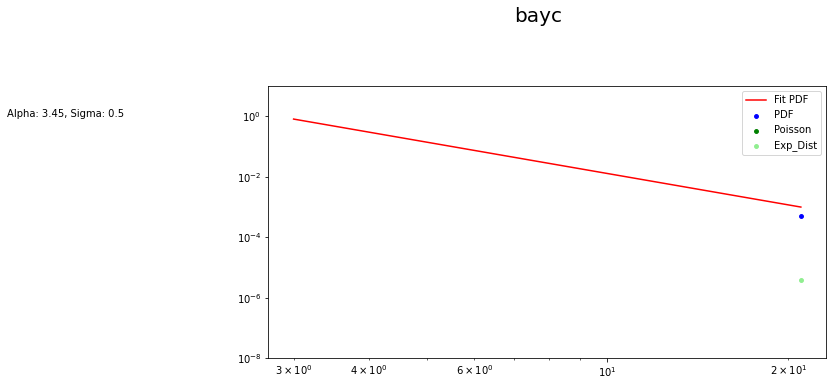

<ipython-input-11-9712afd31475>:107: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  k = np.asarray(k, dtype=np.integer)


Calculating best minimal value for power law fit


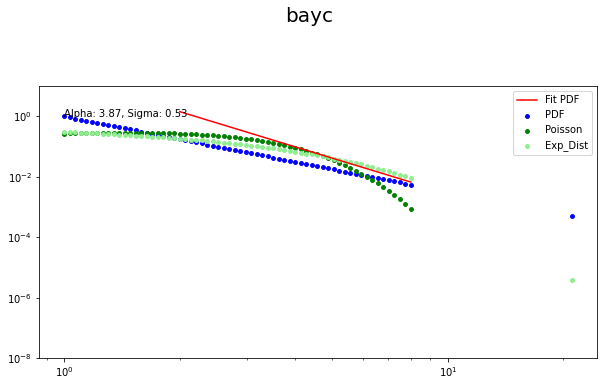

<ipython-input-11-9712afd31475>:107: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  k = np.asarray(k, dtype=np.integer)
<ipython-input-11-9712afd31475>:111: RuntimeWarning: divide by zero encountered in log10
  spacing = np.logspace(np.log10(min(k)), np.log10(max(k)), len(k))
C:\Users\pell\Anaconda3\lib\site-packages\numpy\core\function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
C:\Users\pell\Anaconda3\lib\site-packages\numpy\core\function_base.py:161: RuntimeWarning: invalid value encountered in add
  y += start
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


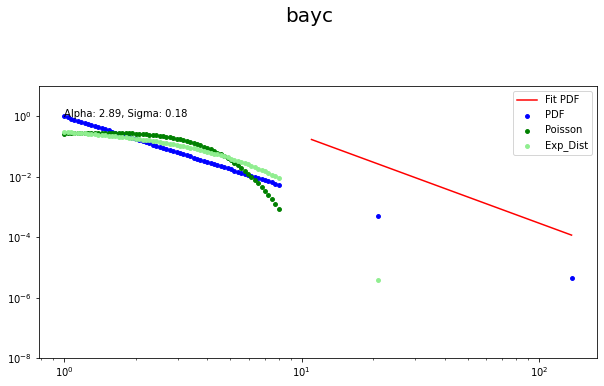

<ipython-input-11-9712afd31475>:107: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  k = np.asarray(k, dtype=np.integer)
<ipython-input-11-9712afd31475>:111: RuntimeWarning: divide by zero encountered in log10
  spacing = np.logspace(np.log10(min(k)), np.log10(max(k)), len(k))
C:\Users\pell\Anaconda3\lib\site-packages\numpy\core\function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
C:\Users\pell\Anaconda3\lib\site-packages\numpy\core\function_base.py:161: RuntimeWarning: invalid value encountered in add
  y += start
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


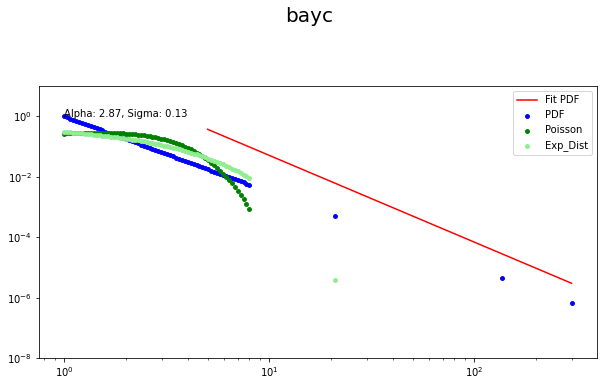

<ipython-input-11-9712afd31475>:107: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  k = np.asarray(k, dtype=np.integer)
<ipython-input-11-9712afd31475>:111: RuntimeWarning: divide by zero encountered in log10
  spacing = np.logspace(np.log10(min(k)), np.log10(max(k)), len(k))
C:\Users\pell\Anaconda3\lib\site-packages\numpy\core\function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
C:\Users\pell\Anaconda3\lib\site-packages\numpy\core\function_base.py:161: RuntimeWarning: invalid value encountered in add
  y += start
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


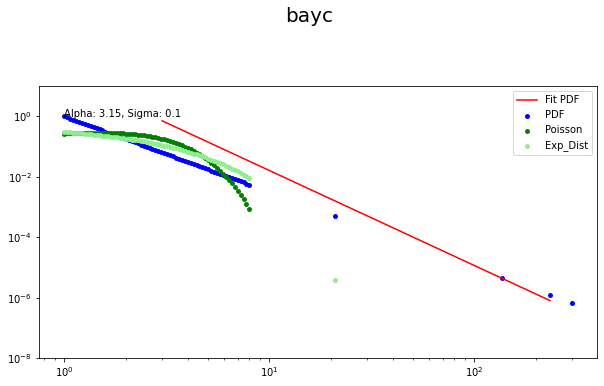

<ipython-input-11-9712afd31475>:107: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  k = np.asarray(k, dtype=np.integer)
<ipython-input-11-9712afd31475>:111: RuntimeWarning: divide by zero encountered in log10
  spacing = np.logspace(np.log10(min(k)), np.log10(max(k)), len(k))
C:\Users\pell\Anaconda3\lib\site-packages\numpy\core\function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
C:\Users\pell\Anaconda3\lib\site-packages\numpy\core\function_base.py:161: RuntimeWarning: invalid value encountered in add
  y += start
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


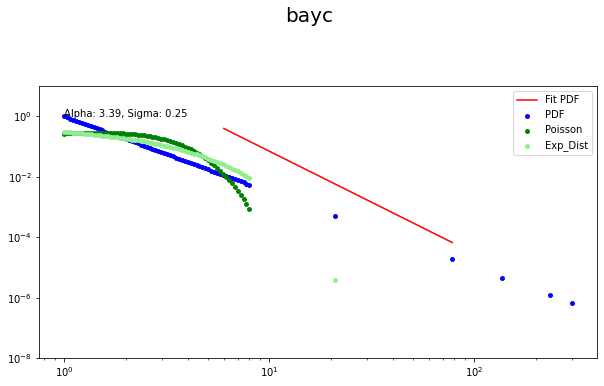

<ipython-input-11-9712afd31475>:107: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  k = np.asarray(k, dtype=np.integer)
<ipython-input-11-9712afd31475>:111: RuntimeWarning: divide by zero encountered in log10
  spacing = np.logspace(np.log10(min(k)), np.log10(max(k)), len(k))
C:\Users\pell\Anaconda3\lib\site-packages\numpy\core\function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
C:\Users\pell\Anaconda3\lib\site-packages\numpy\core\function_base.py:161: RuntimeWarning: invalid value encountered in add
  y += start
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


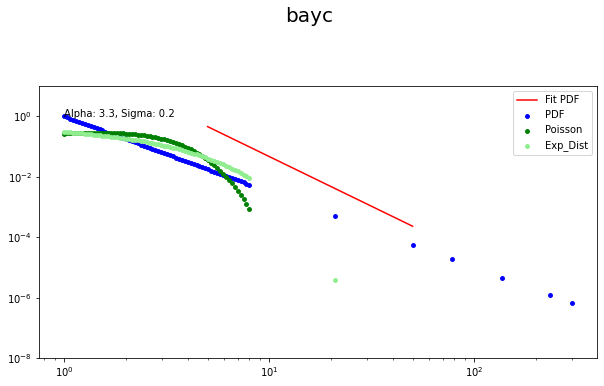

<ipython-input-11-9712afd31475>:107: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  k = np.asarray(k, dtype=np.integer)
<ipython-input-11-9712afd31475>:111: RuntimeWarning: divide by zero encountered in log10
  spacing = np.logspace(np.log10(min(k)), np.log10(max(k)), len(k))
C:\Users\pell\Anaconda3\lib\site-packages\numpy\core\function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
C:\Users\pell\Anaconda3\lib\site-packages\numpy\core\function_base.py:161: RuntimeWarning: invalid value encountered in add
  y += start
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


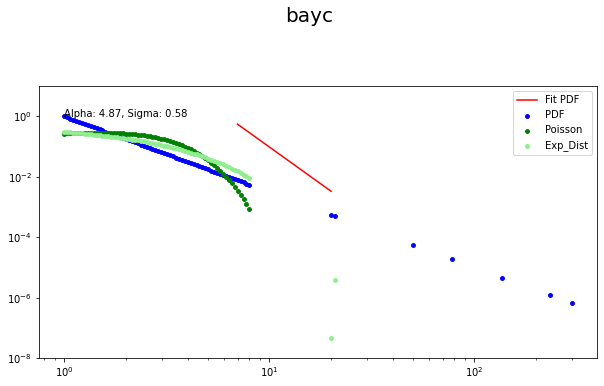

<ipython-input-11-9712afd31475>:107: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  k = np.asarray(k, dtype=np.integer)
<ipython-input-11-9712afd31475>:111: RuntimeWarning: divide by zero encountered in log10
  spacing = np.logspace(np.log10(min(k)), np.log10(max(k)), len(k))
C:\Users\pell\Anaconda3\lib\site-packages\numpy\core\function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
C:\Users\pell\Anaconda3\lib\site-packages\numpy\core\function_base.py:161: RuntimeWarning: invalid value encountered in add
  y += start
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


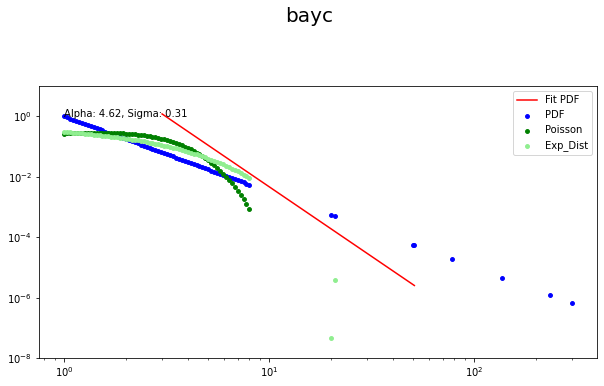

<ipython-input-11-9712afd31475>:107: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  k = np.asarray(k, dtype=np.integer)
<ipython-input-11-9712afd31475>:111: RuntimeWarning: divide by zero encountered in log10
  spacing = np.logspace(np.log10(min(k)), np.log10(max(k)), len(k))
C:\Users\pell\Anaconda3\lib\site-packages\numpy\core\function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
C:\Users\pell\Anaconda3\lib\site-packages\numpy\core\function_base.py:161: RuntimeWarning: invalid value encountered in add
  y += start
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


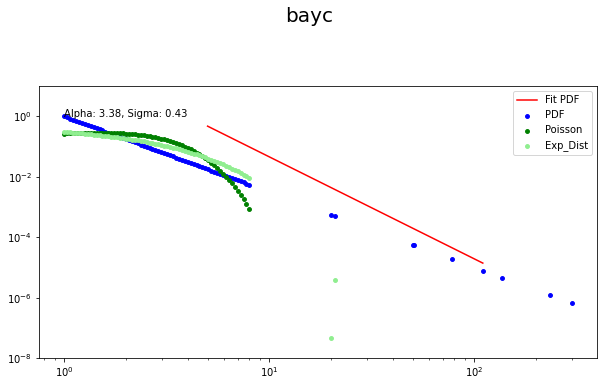

In [11]:
# First attempt:
# Nodes are the wallets. Size of the nodes is the value of a wallet.
# edges are transactions. Size of the transaction is the amount of eth.
# timescale is one day. we plot the graph after one day.
# build the graph

df_time_exmint = df_time.drop(df_time[df_time.from_address == '0x0000000000000000000000000000000000000000'].index)

column_names = ["timebucket", "avgclustering", "reciproccoeff", "asscoeff_directed_out_out", "asscoeff_directed_in_in", "asscoeff_directed_in_out", "asscoeff_undirected_base"]
#column_names = ["timebucket", "k", "Poisson", "Exp_Dist", "avgclustering", "reciproccoeff", "asscoeff_directed_out_out", "asscoeff_directed_in_in", "asscoeff_directed_in_out", "asscoeff_undirected_base"]
df_timebuckets = pd.DataFrame(columns = column_names)

column_names2 = ['timebucket', 'k', 'Poisson', 'Exp_Dist', 'Power_Law']
df_05_1 = pd.DataFrame(columns = column_names2)

# !!!!!!
df_time_exmint.round({'eth_value': 2})

timebuckets = df_time_exmint["date_quantile"].to_numpy()
timebuckets = np.unique(timebuckets)

for jj in range(len(timebuckets)):
    
    k = []
    
    if jj != 20:
    
        df_timebucket = df_time_exmint[(df_time_exmint['date_quantile'] == jj)]

        # we will use a weighted and directed graph.
        graph = nx.DiGraph()

        plot_interval = 24 * 3600 * 10 # 1 day
        start_timestamp = df_timebucket['date'].iloc[0]

        # loop over the pandas dataframe.
        for row in df_timebucket.itertuples():

            # read the values from the dataframe.
            # token_id  blk_timestamp	 eth_value	 weth_value
            from_address = row[3].strip()
            to_address = row[4].strip()
            block = row[6]
            timestamp = row[1]
            token_id = row[5]
            eth_value = row[7]
            weth_value = row[8]

            # make sure both addresses are in the graph.
            if from_address not in graph:
                 graph.add_node(from_address)
            if to_address not in graph:
                graph.add_node(to_address)

            # lookup value of both nodes at the time of this block
            # if (not from_address == '0x0000000000000000000000000000000000000000'):
            #     address = w3.toChecksumAddress(from_address)
            #     value_from = w3.eth.get_balance(address, block_identifier=block)
            # if (not to_address == '0x0000000000000000000000000000000000000000'):
            #     address = w3.toChecksumAddress(to_address)
            #     value_to = w3.eth.get_balance(address, block_identifier=block)

            # set the attributes on this node.
            # TODO: replace dummy values
            nx.set_node_attributes(graph, {from_address:100, to_address:100}, 'value')

            # keep track of how many trades a wallet has done.
            trades = nx.get_node_attributes(graph, "trades")
            if from_address in trades:
                nx.set_node_attributes(graph, {from_address:trades[from_address] + 1}, 'trades')
            else:
                nx.set_node_attributes(graph, {from_address:1}, 'trades')
            if to_address in trades:
                nx.set_node_attributes(graph, {to_address:trades[to_address] + 1}, 'trades')
            else:
                nx.set_node_attributes(graph, {to_address:1}, 'trades')

            # check if this NFT has already been sold and if yes, remove the old sale.
            removeEdges = []
            for (u,v,d) in graph.edges.data():
                if d['token'] == token_id:
                    removeEdges.append((u,v))
            # we need to remove them in a seperate step, since otherwise we change the datastructure that we are iterating over.
            for (u,v) in removeEdges:
                graph.remove_edge(u,v)

            # add an edge for the transaction.
            value = eth_value + weth_value # currently we do not care if it was eth or weth
            graph.add_edge(from_address, to_address, weight=value, token=token_id) # keep track of token id by adding it to the edge.

        # Directed
        avgclustering = nx.average_clustering(graph)
        reciproccoeff = nx.reciprocity(graph)
        asscoeff_directed_out_out = nx.degree_pearson_correlation_coefficient(graph, x='out', y='out', weight='weight')
        asscoeff_directed_in_in = nx.degree_pearson_correlation_coefficient(graph, x='in', y='in', weight='weight')
        asscoeff_directed_in_out = nx.degree_pearson_correlation_coefficient(graph, x='in', y='out', weight='weight')

        # Undirected
        asscoeff_undirected_base = nx.degree_pearson_correlation_coefficient(graph.to_undirected(), weight='weight')

        df_timebuckets = df_timebuckets.append({'timebucket': jj, 'avgclustering': avgclustering, 'reciproccoeff': reciproccoeff, 'asscoeff_directed_out_out': asscoeff_directed_out_out, 'asscoeff_directed_in_in': asscoeff_directed_in_in, 'asscoeff_directed_in_out': asscoeff_directed_in_out, 'asscoeff_undirected_base': asscoeff_undirected_base}, ignore_index=True)


        k = np.asarray([d for d in dict(graph.degree()).values()])

        # !!!!!!
        k = np.asarray(k, dtype=np.integer)

        avg_k = np.average(k)
        #spacing = np.linspace(min(k),max(k),len(k))
        spacing = np.logspace(np.log10(min(k)), np.log10(max(k)), len(k))

        fit = powerlaw.Fit(k)
        alpha = fit.power_law.alpha
        sigma = fit.power_law.sigma
        alpha_constant = f"Alpha: {round(alpha, 2)}"
        sigma_constant = f"Sigma: {round(sigma, 2)}"
        alpha_sigma_constant = f"{alpha_constant}, {sigma_constant}"

        #fig, ax = plt.subplots(1, 1)
        fig, ax = plt.subplots(figsize=(10, 5))

        # Fit PDF
        fit.power_law.plot_pdf(color='r')

        # PDF

        ## cannot convert float infinity to integer
        #def round_int(x):
        #    if x in [float("-inf"),float("inf")]: return float("nan")
        #     return int(round(x))
        #round_int(k)

        #powerlaw.plot_pdf(k,color='b',marker='o')
        #plt.plot(spacing,myfunc(spacing,4))

        numnodes = graph.number_of_nodes()
        sumdegree = sum(k)

        # Lambda: mean number of successes that occur during a specific interval
        k_a = sumdegree / numnodes

        # k: number of successes
        num_k = len(k)

        #title = titlelist[jj]

        for i in spacing:
            fact_k = factorial(i, exact=False)
            poisson = (k_a**i / fact_k) * e**(-1*k_a)
            exp_dist = k_a**(-1) * e**(-i/k_a)
            power_law = i**(-2.5)

            df_05_1 = df_05_1.append({'timebucket': jj, 'k': i, 'Poisson': poisson, 'Exp_Dist': exp_dist, 'Power_Law': power_law}, ignore_index=True)

        ax = plt.gca()

        fig.suptitle(title, fontsize=20, y=1.1, ha="center")
        plt.scatter(df_05_1.k, df_05_1.Power_Law, label='Power-Law Distribution', s=15, color='blue')
        plt.scatter(df_05_1.k, df_05_1.Poisson, label='Poisson', s=15, color='green')
        plt.scatter(df_05_1.k, df_05_1.Exp_Dist, label='Exponential Distribution', s=15, color='lightgreen')
        plt.legend(['Fit PDF', 'PDF', 'Poisson', 'Exp_Dist'], loc = 'upper right')
        plt.text(1, 1, alpha_sigma_constant, fontsize = 10)

        ymin = 10**(-8)
        ymax = 10**1
        ax = plt.gca()
        ax.set_ylim([ymin, ymax])

        plt.show()
        #df_05_1 = df_05_1[0:0]
    